## 一、大模型的结构进化  
Transformer 最初被设计为Encoder-decoder结构，用于机器翻译    

Encoder负责理解，采用双向注意力，能同时看到句子的前后信息，将文字转化为语义向量    

Decoder负责表达，采用单向注意力机制，看到生成的词，将语义向量转化为文字输出  



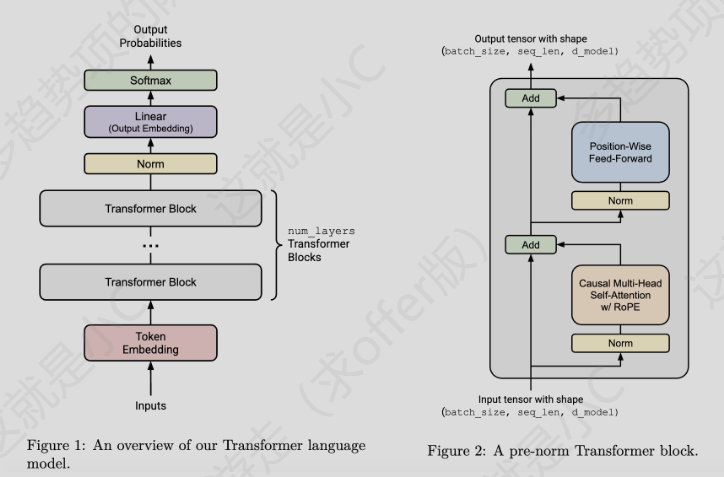

## 二、整体架构 

### 2.1原材料加工（嵌入与位置编码）  
1）输入：原始的文本，经过Tokenizer转换后编程一个二维整数张量  
形状【batch_size, seq_len】-> 整数ID之间没有数学相关性，需要将其映射到一个高维的连续空间  
2）映射阶段：Embedding   
经过分词器切分文本成一个个词元ID后，模型会通过一个查找表将每个ID映射为一个固定维度的稠密向量  
物理意义：该向量捕捉了词源的语义信息。在向量空间中，语义相近的词距离会更近  
输入形式：假设输入序列长度为s，嵌入维度为d，则嵌入后，原本的整数序列变成了(s,d)的矩阵  


### 2.2 核心动力（Transformer Block） 
#### 负责“信息交换”的注意力层和负责“特征加工”的前馈网络层


#### 2.1.1 核心逻辑：QKV  　
Q:搜索框，代表“我要找什么“  

K：条目的标签，代表“我这里有什么”  

V：条目的具体内容：代表“我包含的实际数值信息”   

1）构造向量：输入向量X分别与三个随机初始化的矩阵Q，K，V进行矩阵乘法，得到q,k,v  

2）因果多头自注意力的数学表达：  
- 计算QK的点积，这代表了词i对词j的关注度得分  
- 除以根号dk，进行缩放，防止点积过大，梯度爆炸  
- 对点积进行softmax，得到注意力权重  
- 对V进行矩阵乘法，得到最终的输出  
- 将多个头连接起来  
$\text selfAttention = \sum_{h=1}^{H} \text{softmax}(QK^T / \sqrt{d_k})V$


#### 2.2.2 进阶组件：多头，掩码与优化

1）多头机制  
逻辑：不直接在全维度进行一次注意力，而是将其拆分为h个低维的”头“    

目的：允许模型在不同子空间进行学习  

维度演变:    

- 输入：[batch_size, seq_len, d_model]   
- 投影：分别乘以Q，K，V的权重矩阵，得到三个[batch_size, seq_len, d_model]张量  
- 拆分：重塑为[batch_size, seq_len, h, d_model],并转置为[batch_size, h, seq_len, d_head]，其中d_head = d_model / h  
- 合并：计算完注意力后，将所有头进行拼接，再通过一个输出线性层W还原为[batch_size, seq_len, d_model]

2）因果掩码  
逻辑：在Decoder-only模型中，构造一个下三角矩阵  
技术细节：将未来的Token对应的位置设置为-inf，使模型在预测第i个词语时，绝对看不见第i+1个词的内容  

3）计算优化：FlashAttention   
逻辑：标准注意力的显存占用随序列长度平方级增长 
技术细节：FlashAttention通过分块重计算，减少了GPU显存的读写，提升了训练速度  


#### 2.2.3 位置编码  
逻辑：在投影得到QK后，对其应用复数域货旋转矩阵变换  
意义：给Q和K注入旋转相位，使他们的点积结果直接受到相对距离的影响  


#### 2.2.4 前馈网络（FFN/SwiGlu）  
1）逻辑：在注意力层完成空间维度的信息交换后，FFN在通道维度进行深度加工  
2）技术细节：  
- 经典结构：传统FFN由两个线性层组成，中间夹一个非线性激活函数（ReLu） 公式为：$FFN(x)=max(0,W_1x+b_1)+W_2x+b_2$  
- 去掉偏执：在Linear层中去掉偏执项可以让训练更加稳定
- SwiGlu结构：SwiGlu结构由两个线性层组成，中间夹一个非线性激活函数（Swish） 数学公式为：$SwiGlu(x)=W_1x+b_1+W_2x+b_2$  
- 改进结构：改进结构由两个线性层组成，中间夹一个非线性激活函数
- 参数匹配：使用Gated结构会多出一组参数，为了保证总参数量不变，工程师通常会将中间隐藏层的维度缩小为原来的2/3    
3）维度操作  
- 升维：通常将$d_model$提升为$d_f$
- 形状变化：[batch_size, seq_len, dmodel] -> [batch_size, seq_len, d_ff] -> [batch_size, seq_len, dmodel]
  

#### 2.2.5 层归一化  
1）为了让数据在穿过几十层网络后依然保持正常的数值分布，必须进行归一化  
- LayerNorm(LN):通过减去均值除以标准差，激活值标准化  
- RMSNorm：只进行方差缩放  
- 将向量维度从d_model映射回vocab_size 
- 形状变化：[batch_size, seq_len, d_model] -> [batch_size, seq_len, vocab_size]

2）PRE or POST:  
- POST: 原始Transformer将归一化放在残差连接之后。虽然性能略高，但训练不稳定，需要warm-up 
- PRERE: 将归一化在自注意力层或FFN之前，相当于为梯度开辟了一条恒等变换的通路，让几百层的网络也可以稳定训练  


3）残差连接  
在FFN和注意力层旁边，总有一条直接绕过去的路径，即$x+F(x)$  
允许梯度直接从深层传播到浅层，解决了深层神经网络中的梯度消失  

4）Softmax  
对Vocab_size维度进行Softmax，得到每一个词出现的概率  
训练目标：在训练时，知道位置t的真实标签为t+1.如果模型给真实标签分配概率越大，交叉熵的损失越少